#### **Library imports**

In [1]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Hyperparams and loading data**

In [6]:
train_edges = np.load('anime/train_edges.npy')
user_list = train_edges[:, 0]
item_list = train_edges[:, 1]
rating_list = train_edges[:, 2].astype('float32')

n_users = user_list.max() + 1 
n_items = item_list.max() + 1
n_samples = len(rating_list)

n_users, n_items, n_samples

(2000, 1197, 415324)

In [7]:
0.05 * n_samples # 5%

20766.2

#### **Defining collaborative filtering**

In [8]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

In [9]:
def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Code for meta attack**

In [21]:
# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 1
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
lr = 200
T = 300
Delta = 10000
n_factors = 64
save_results = True
manual_gradients = True
retain_graph = True 
create_graph = False

# store loss results in this list and later convert to dataframe 
results = []

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
# perturbations['accuracy'] = []
perturbations['accuracy_before'] = []
perturbations['accuracy_after'] = []
perturbations['loss_before'] = []
perturbations['loss_after'] = []

# print hyperparam config
print('-> Learning rate: ', lr)
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
print('-> Manual gradients: ', manual_gradients)
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)
perturbs = torch.ones_like(ratings).bool()

# define model and it's parameters
model = CollaborativeFiltering(n_users, n_items, n_factors)
model.to(device)

if manual_gradients == True:
    p1, p2 = model.parameters()
else:
    optimizer = torch.optim.SGD(model.parameters(), lr = 100)

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # makes loss reproducible for each iteration in Delta
    torch.manual_seed(0)

    # reset model paramters 
    for layer in model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    model.train()

    # inner loop training process
    if manual_gradients == True:
        for i in range(T):
            y_hat = model(users, items)
            loss = loss_fn(y_hat, ratings)
            results.append([delta, i, loss.item()])

            # compute inner parameter gradients
            p1_grad = torch.autograd.grad(loss, p1, retain_graph=retain_graph, create_graph=create_graph)
            p2_grad = torch.autograd.grad(loss, p2, retain_graph=retain_graph, create_graph=create_graph)

            # update inner parameters
            with torch.no_grad():
                p1_new = p1 - lr * p1_grad[0]
                p2_new = p2 - lr * p2_grad[0]
                p1.copy_(p1_new)
                p2.copy_(p2_new)
    else:
        for i in range(T):
            y_hat = model(users, items)
            loss = loss_fn(y_hat, ratings)
            results.append([delta, i, loss.item()])

            # use torch.optim optimizer to compute gradients
            optimizer.zero_grad()
            loss.backward(retain_graph=retain_graph, create_graph=create_graph)
            optimizer.step()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # compute training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy_before'].append(get_accuracy(y_hat, ratings))
        perturbations['loss_before'].append(loss_fn(y_hat, ratings).item())

        # compute training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy_after'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after'].append(loss_fn(y_hat_masked, ratings_masked).item())
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1
        perturbs[best_edge] = False

        # keep track of perturbations and accuracy
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
results = pd.DataFrame(results, columns = ['perturbs', 'iters', 'loss'])
perturbations = pd.DataFrame(perturbations)
losses = results[results.iters == T - 1][['perturbs', 'loss']].copy()

# save results in CSV format
filename = 'anime_meta_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors) + ('_manual' if manual_gradients else '_auto') + ('_r' if retain_graph else '_c')
if save_results:
    # results.to_csv('results/results_' + filename + '.csv')
    perturbations.to_csv('results/perturbations_' + filename + '.csv')
    losses.to_csv('results/losses_' + filename + '.csv')

-> Learning rate:  200
-> T:  300
-> Delta: 10000 (2.41%)
-> Embedding size:  64
-> Device:  cuda:1
-> Manual gradients:  True
-> Retain graph:  True
-> Create graph:  False
-> Save results:  True


-> Perturbations:   4%|▎         | 365/10000 [04:38<2:01:56,  1.32it/s]

In [19]:
perturbations

,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after
0,411277,0.000063,0.863191,0.863191,0.327948,0.327948


#### **More plots**

In [49]:
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges', 'Accuracy excluding perturbed edges', 'Loss including perturbed edges', 'Loss excluding perturbed edges']
perturbations_reset

,# Perturbations,Perturbed edge,Meta gradient,Accuracy including perturbed edges,Accuracy excluding perturbed edges,Loss including perturbed edges,Loss excluding perturbed edges
0,0,1223808,0.000006,0.841843,0.841843,0.354682,0.354682
1,1,2178286,0.000006,0.841847,0.841848,0.354672,0.354668
2,2,1624784,0.000006,0.841820,0.841821,0.354710,0.354701
3,3,1799168,0.000005,0.841826,0.841827,0.354709,0.354697
4,4,2061428,0.000005,0.841819,0.841820,0.354719,0.354703
...,...,...,...,...,...,...,...
1995,1995,245798,0.000003,0.841199,0.841705,0.360304,0.355606
1996,1996,3077242,0.000003,0.841196,0.841703,0.360305,0.355606
1997,1997,2276642,0.000003,0.841190,0.841697,0.360309,0.355608
1998,1998,1380977,0.000003,0.841190,0.841697,0.360311,0.355607


In [50]:
filename

'netflix_meta_Delta=2000_T=100_LR=10000_Factors=64_manual_r'

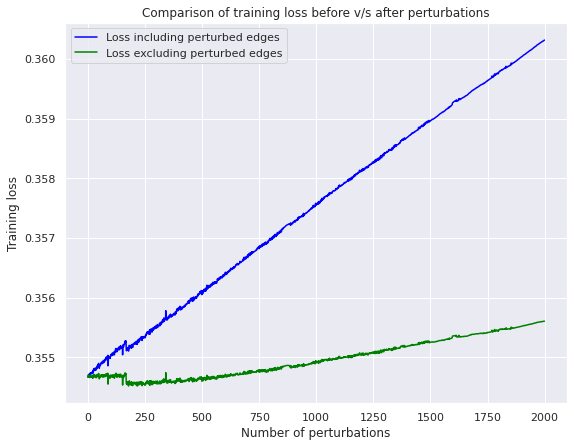

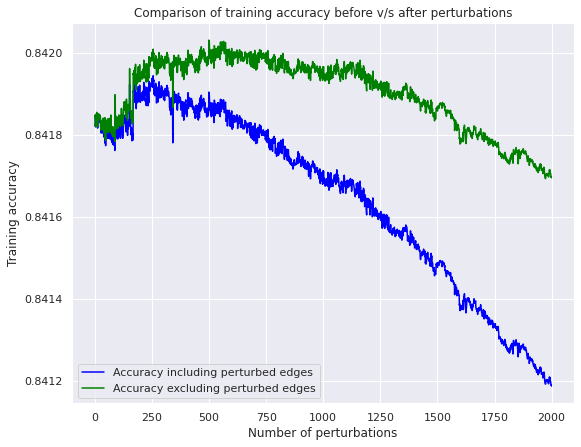

In [51]:
sns.set_theme()
figsize = (9, 7)

# Loss plot

plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss including perturbed edges', color = 'blue').set_title('Comparison of training loss before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training loss')
plt.legend(labels = ['Loss including perturbed edges', 'Loss excluding perturbed edges'], loc = 'upper left')
fig.savefig('plots/losses_' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy including perturbed edges', color = 'blue').set_title('Comparison of training accuracy before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training accuracy')
plt.legend(labels = ['Accuracy including perturbed edges', 'Accuracy excluding perturbed edges'])
fig.savefig('plots/accuracy_' + filename)
plt.show()